In [94]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

dfs = []
for i in range(1, 5):
    path = f'/kaggle/input/unsw-nb15/UNSW-NB15_{i}.csv'
    dfs.append(pd.read_csv(path, header=None))

combined_data = pd.concat(dfs).reset_index(drop=True)


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

***Importing Libraries***


In [95]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dense, Dropout, Input

In [96]:
import warnings
warnings.filterwarnings('ignore') 


***Data Exploration***

In [97]:
combined_data.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


In [98]:
# Load and set column names
df_cols = pd.read_csv('/kaggle/input/unsw-nb15/NUSW-NB15_features.csv', encoding='ISO-8859-1')
combined_data.columns = df_cols['Name']
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  Sload             float64
 15  Dload             float64
 16  Spkts             int64  
 17  Dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  Sjit          

In [99]:
combined_data.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


***Data Cleaning***

In [100]:
combined_data['attack_cat'] = combined_data['attack_cat'].fillna(value='normal').apply(lambda x: x.strip().lower())
combined_data['attack_cat'] = combined_data['attack_cat'].replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())
combined_data['ct_flw_http_mthd'] = combined_data['ct_flw_http_mthd'].fillna(value=0)
combined_data['is_ftp_login'] = combined_data['is_ftp_login'].fillna(value=0)
combined_data['is_ftp_login'] = np.where(combined_data['is_ftp_login']>1, 1, combined_data['is_ftp_login'])
combined_data['service'] = combined_data['service'].apply(lambda x:"None" if x=='-' else x)
combined_data['ct_ftp_cmd'] = combined_data['ct_ftp_cmd'].replace(to_replace=' ', value=0).astype(int)
combined_data[['service','ct_flw_http_mthd','is_ftp_login','ct_ftp_cmd','attack_cat','Label']]

Name,service,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,attack_cat,Label
0,dns,0.0,0.0,0,normal,0
1,None,0.0,0.0,0,normal,0
2,dns,0.0,0.0,0,normal,0
3,dns,0.0,0.0,0,normal,0
4,dns,0.0,0.0,0,normal,0
...,...,...,...,...,...,...
2540042,ftp-data,0.0,0.0,0,normal,0
2540043,ftp,0.0,1.0,2,normal,0
2540044,ftp,0.0,1.0,2,normal,0
2540045,http,2.0,0.0,0,normal,0


In [101]:
combined_data['attack_cat'].nunique()

10

***Data Analysis & preprocessing***

Summary Statistics of Connection Duration by Label:
                    count      mean        std       min       25%       50%  \
attack_cat                                                                     
analysis           2677.0  1.416942   7.220232  0.000000  0.000005  0.000009   
backdoor           2329.0  2.224558   9.618294  0.000000  0.000005  0.000009   
dos               16353.0  2.448795  10.103664  0.000000  0.000005  0.000009   
exploits          44525.0  2.122902   7.404824  0.000000  0.000009  0.506770   
fuzzers           24246.0  2.673938   9.441919  0.000000  0.000010  0.589508   
generic          215481.0  0.053270   1.194481  0.000000  0.000004  0.000008   
normal          2218764.0  0.648411  14.783481  0.000000  0.001111  0.020046   
reconnaissance    13987.0  1.005046   4.929644  0.000000  0.000008  0.194530   
shellcode          1511.0  0.362856   0.832788  0.000001  0.000008  0.000032   
worms               174.0  1.333305   2.146530  0.000002  0.260383  

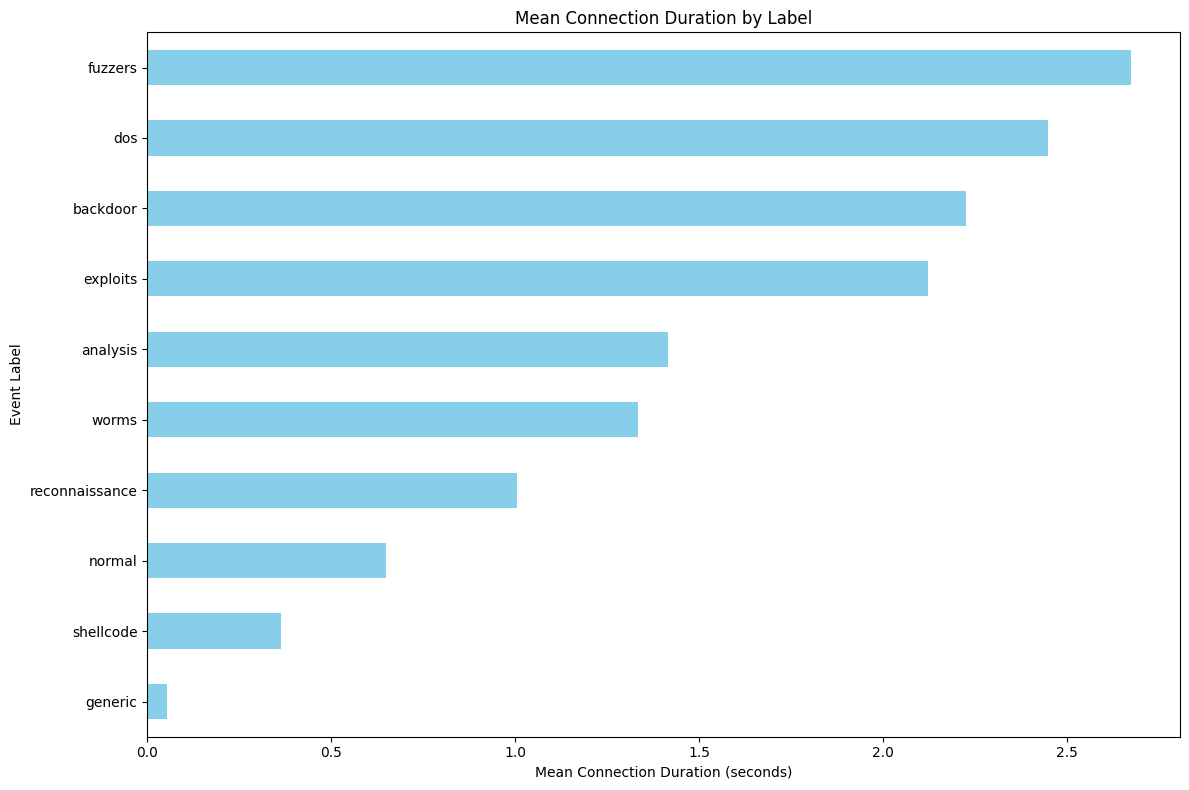

In [102]:
import pandas as pd

# Ensure 'connection_duration' is numeric
combined_data['dur'] = pd.to_numeric(combined_data['dur'], errors='coerce')

# Group by 'event_label' and calculate summary statistics for 'dur'
connection_duration_by_label = combined_data.groupby('attack_cat')['dur'].describe()

# You might be specifically interested in certain statistics, like mean and median:
mean_connection_duration_by_label = combined_data.groupby('attack_cat')['dur'].mean()
median_connection_duration_by_label = combined_data.groupby('attack_cat')['dur'].median()

# Print the summary statistics
print("Summary Statistics of Connection Duration by Label:")
print(connection_duration_by_label)

# If you want to visualize this, a bar chart for the mean or median connection duration can be insightful:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
mean_connection_duration_by_label.sort_values().plot(kind='barh', color='skyblue')
plt.title('Mean Connection Duration by Label')
plt.xlabel('Mean Connection Duration (seconds)')
plt.ylabel('Event Label')
plt.tight_layout()
plt.show()



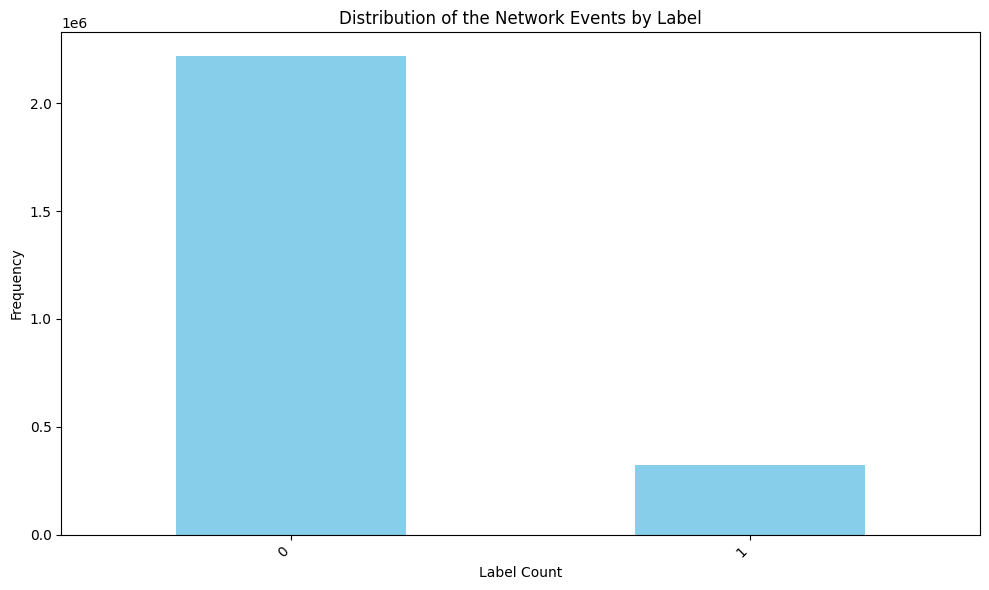

In [103]:
import pandas as pd
import matplotlib.pyplot as plt

label_count = combined_data['Label'].value_counts()

# Visualization: Bar chart displaying the frequency of each network event type
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
label_count.plot(kind='bar', color='skyblue')
plt.title('Distribution of the Network Events by Label')
plt.xlabel('Label Count')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate labels to fit them better
plt.tight_layout()  # Adjust the layout to make room for the rotated labels

plt.show()


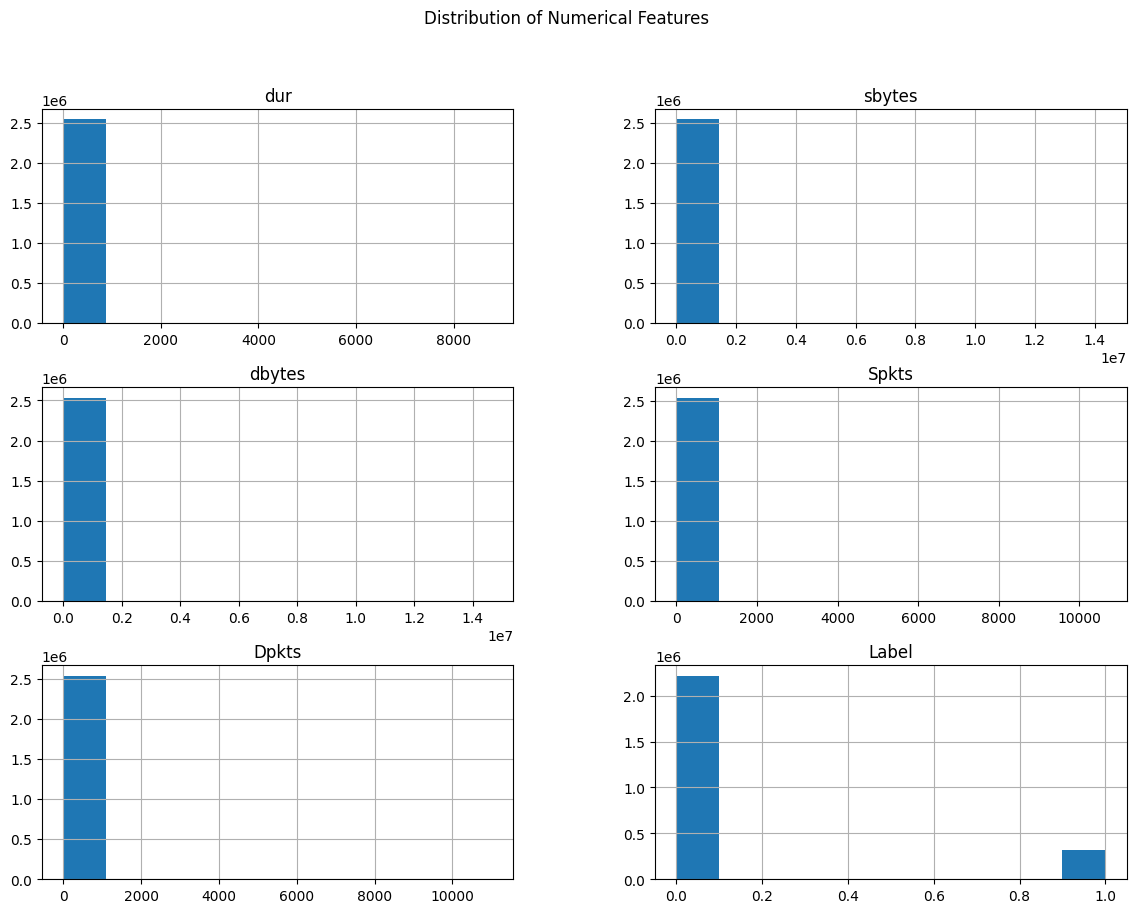

In [104]:
# Distribution of numerical features (e.g., orig_bytes, resp_bytes)
numerical_features = ['dur', 'sbytes', 'dbytes', 'Spkts', 'Dpkts', 'Label']
combined_data[numerical_features].hist(figsize=(14, 10))
plt.suptitle('Distribution of Numerical Features')
plt.show()


In [105]:
import pandas as pd

# Count occurrences of each (source_ip_address, destination_ip_address) pair
pair_counts = combined_data.groupby(['srcip', 'dstip']).size().reset_index(name='connections')

# Sort pairs by the number of connections, descending
top_pairs = pair_counts.sort_values(by='connections', ascending=False).head(10)

print(top_pairs)


              srcip           dstip  connections
182    175.45.176.1  149.171.126.18        52942
76   149.171.126.18    175.45.176.3        48782
206    175.45.176.3  149.171.126.18        45072
65   149.171.126.15    175.45.176.3        44873
203    175.45.176.3  149.171.126.15        42760
58   149.171.126.14    175.45.176.1        40995
178    175.45.176.1  149.171.126.14        36059
74   149.171.126.18    175.45.176.1        32825
162    175.45.176.0  149.171.126.10        30854
40   149.171.126.10    175.45.176.0        30359


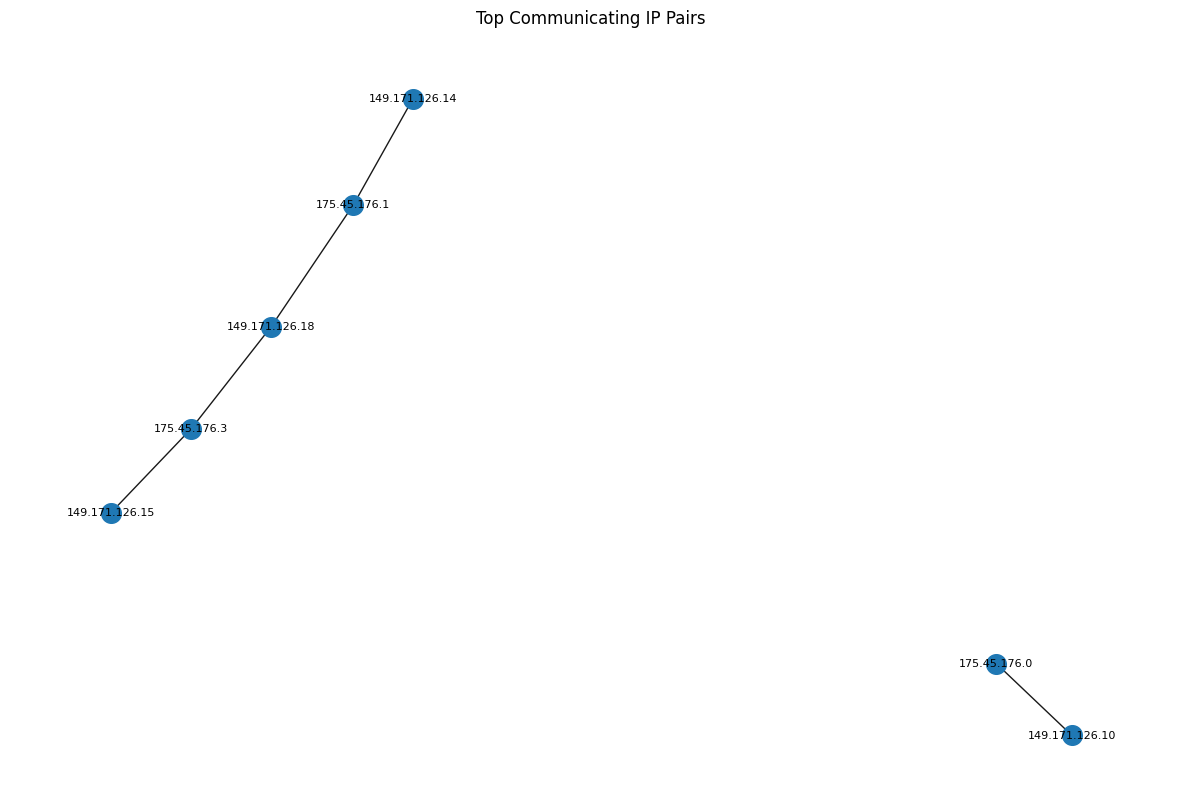

In [106]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Add edges from top_pairs
# Assuming 'top_pairs' contains the top communicating IP pairs
for index, row in top_pairs.iterrows():
    G.add_edge(row['srcip'], row['dstip'], weight=row['connections'])

# Draw the network
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=5, seed=42)  # For consistent layout
edges = nx.draw_networkx_edges(G, pos, alpha=0.9)
nodes = nx.draw_networkx_nodes(G, pos, node_size=200)
labels = nx.draw_networkx_labels(G, pos, font_size=8)
plt.title('Top Communicating IP Pairs')
plt.axis('off')  # Turn off the axis
plt.show()


In [107]:
combined_data.drop(columns=['srcip','sport','dstip','dsport','Label'],inplace=True)

***Data Splitting***


In [108]:
train, test = train_test_split(combined_data,test_size=0.2,random_state=16)
train, val = train_test_split(train,test_size=0.2,random_state=16)

In [109]:
x_train, y_train = train.drop(columns=['attack_cat']), train[['attack_cat']]
x_test, y_test = test.drop(columns=['attack_cat']), test[['attack_cat']]
x_val, y_val = val.drop(columns=['attack_cat']), val[['attack_cat']]

In [110]:
cat_col = ['proto', 'service', 'state']
num_col = list(set(x_train.columns) - set(cat_col))

***Correlation Matrix***

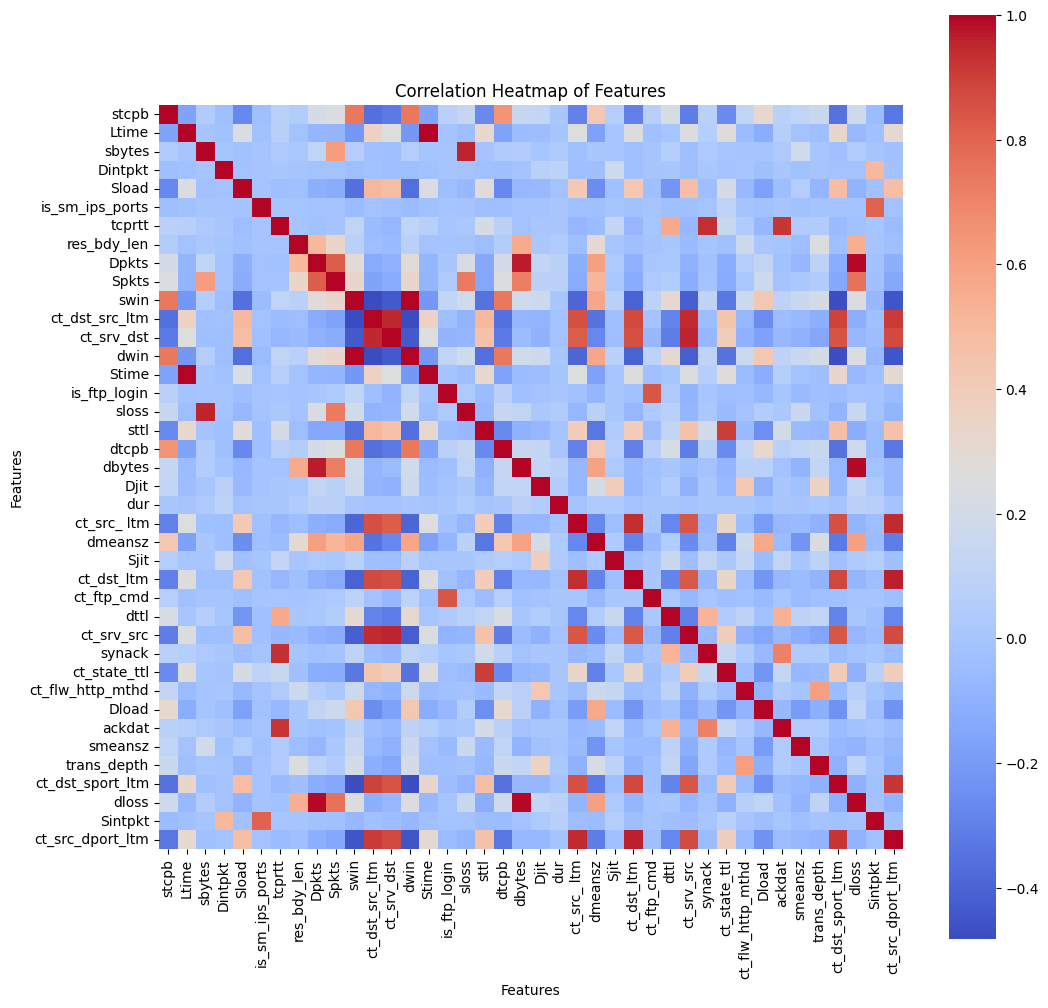

In [111]:
correlation_matrix = train[num_col].corr()


plt.figure(figsize=(12, 12))  


sns.heatmap(correlation_matrix, cmap='coolwarm', square=True)

# Add labels and title
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Correlation Heatmap of Features')

# Rotate x-axis labels for better readability with many features
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Show the plot
plt.show()


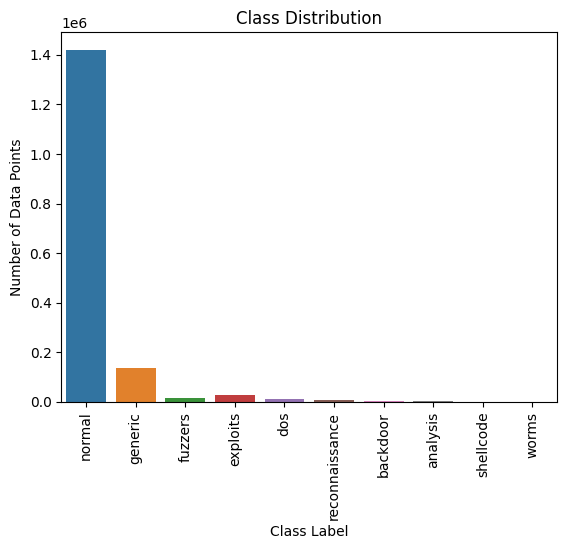

In [112]:
import warnings
warnings.filterwarnings('ignore') 
labels = train['attack_cat']

# Create a count plot with Seaborn
sns.countplot(x=labels)

# Add labels and title
plt.xlabel('Class Label')
plt.ylabel('Number of Data Points')
plt.title('Class Distribution')

# Rotate x-axis labels for better readability if there are many classes
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [113]:
del combined_data


In [114]:
del train
del test

***Scaling and Transformation***

In [115]:
scaler = StandardScaler()
scaler = scaler.fit(x_train[num_col])
x_train[num_col] = scaler.transform(x_train[num_col])
x_test[num_col] = scaler.transform(x_test[num_col])
x_val[num_col] = scaler.transform(x_val[num_col])

In [116]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse=False), cat_col)], remainder='passthrough')
x_train = np.array(ct.fit_transform(x_train))
x_test = np.array(ct.transform(x_test))
x_val = np.array(ct.transform(x_val))

In [117]:
labels = y_train['attack_cat'].unique()
labels

array(['normal', 'generic', 'fuzzers', 'exploits', 'dos',
       'reconnaissance', 'backdoor', 'analysis', 'shellcode', 'worms'],
      dtype=object)

In [118]:
import warnings
warnings.filterwarnings('ignore') 


In [119]:
ct1 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(categories=[labels],sparse=False), ['attack_cat'])], remainder='passthrough')


In [120]:
y_train = np.array(ct1.fit_transform(y_train))
y_test = np.array(ct1.transform(y_test))
y_val = np.array(ct1.transform(y_val))

***LSTM Model Building***

In [121]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dense, Dropout

In [122]:
# Define model parameters
n_features = x_train.shape[1]  # Number of features from training data

# Define the model
model = Sequential()

# First convolutional block
model.add(Conv1D(filters=16, kernel_size=1, activation='relu', input_shape=(n_features,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# First LSTM block
model.add(LSTM(units=16, return_sequences=True))
#model.add(Dropout(0.2))  # Added dropout after LSTM

# Second convolutional block
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Second LSTM block
model.add(LSTM(units=32, return_sequences=True))
#model.add(Dropout(0.2))  # Added dropout after LSTM

# Third convolutional block
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Third LSTM block
model.add(LSTM(units=64))
#model.add(Dropout(0.2))  # Added dropout after LSTM

# Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # Adjusted dropout rate for dense layer

model.add(Dense(10, activation='softmax'))  # Output layer for 10 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 204, 16)        │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 102, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 102, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 102, 16)        │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 46, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 23, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,618 (236.79 KB)

 Trainable params: 60,394 (235.91 KB)

 Non-trainable params: 224 (896.00 B)

In [124]:
def create_model():
    n_features = x_train.shape[1]  # Number of features from training data

    # Define the model
    model = Sequential()

    # First convolutional block
    model.add(Conv1D(filters=16, kernel_size=1, activation='relu', input_shape=(n_features,1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())

    # First LSTM block
    model.add(LSTM(units=16, return_sequences=True))
    #model.add(Dropout(0.2))  # Added dropout after LSTM

    # Second convolutional block
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())

    # Second LSTM block
    model.add(LSTM(units=32, return_sequences=True))
    #model.add(Dropout(0.2))  # Added dropout after LSTM

    # Third convolutional block
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())

    # Third LSTM block
    model.add(LSTM(units=64))
    #model.add(Dropout(0.2))  # Added dropout after LSTM

    # Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))  # Adjusted dropout rate for dense layer

    model.add(Dense(10, activation='softmax'))  # Output layer for 10 classes
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return model
    

In [125]:
history = model.fit(x_train, y_train, epochs=5, batch_size=64,validation_data=(x_val,y_val))

 #Evaluate the model
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

Epoch 1/5
25401/25401 ━━━━━━━━━━━━━━━━━━━━ 493s 19ms/step - accuracy: 0.9703 - loss: 0.0818 - precision: 0.9890 - recall: 0.9570 - val_accuracy: 0.9768 - val_loss: 0.0588 - val_precision: 0.9906 - val_recall: 0.9666
Epoch 2/5
25401/25401 ━━━━━━━━━━━━━━━━━━━━ 489s 19ms/step - accuracy: 0.9763 - loss: 0.0610 - precision: 0.9899 - recall: 0.9667 - val_accuracy: 0.9769 - val_loss: 0.0590 - val_precision: 0.9896 - val_recall: 0.9679
Epoch 3/5
25401/25401 ━━━━━━━━━━━━━━━━━━━━ 484s 19ms/step - accuracy: 0.9770 - loss: 0.0584 - precision: 0.9904 - recall: 0.9675 - val_accuracy: 0.9769 - val_loss: 0.0569 - val_precision: 0.9914 - val_recall: 0.9667
Epoch 4/5
25401/25401 ━━━━━━━━━━━━━━━━━━━━ 488s 19ms/step - accuracy: 0.9772 - loss: 0.0575 - precision: 0.9904 - recall: 0.9677 - val_accuracy: 0.9780 - val_loss: 0.0544 - val_precision: 0.9907 - val_recall: 0.9691
Epoch 5/5
25401/25401 ━━━━━━━━━━━━━━━━━━━━ 480s 19ms/step - accuracy: 0.9779 - loss: 0.0558 - precision: 0.9906 - recall: 0.9686 - val_a

In [126]:
y_pred = model.predict(x_test)  # Assuming X_test is your test data

15876/15876 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step


***LSTM Model Evaluation***

In [127]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [132]:
import warnings

from sklearn.metrics import (

    accuracy_score,

    classification_report,

    confusion_matrix,

    roc_auc_score,

    hamming_loss,

    f1_score

)
 
warnings.filterwarnings('ignore')
 
def print_score(clf, x_train, y_train, x_test, y_test, train=True):

    if train:

        y_pred_train = (clf.predict(x_train) > 0.5).astype(int)

        y_pred_prob_train = clf.predict(x_train)
 
        print("Train Result: \n")

        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, y_pred_train)))

        print("classification report: \n {}\n".format(classification_report(y_train, y_pred_train)))

        print("confusion_matrix: \n {}\n".format(confusion_matrix(y_train.argmax(axis=1), y_pred_train.argmax(axis=1))))

        print("ROC_AUC_SCORE: \n {}\n".format(roc_auc_score(y_train, y_pred_prob_train, average='macro', multi_class='ovr')))

        print("hamming_loss: \n {}\n".format(hamming_loss(y_train, y_pred_train)))

        print("f1_score: \n {}\n".format(f1_score(y_train, y_pred_train, average='macro')))

    else:

        y_pred_test = (clf.predict(x_test) > 0.5).astype(int)

        y_pred_prob_test = clf.predict(x_test)
 
        print("Test Result: \n")

        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, y_pred_test)))

        print("classification report: \n {}\n".format(classification_report(y_test, y_pred_test)))

        print("confusion_matrix: \n {}\n".format(confusion_matrix(y_test.argmax(axis=1), y_pred_test.argmax(axis=1))))

        print("ROC_AUC_SCORE: \n {}\n".format(roc_auc_score(y_test, y_pred_prob_test, average='macro', multi_class='ovr')))

        print("hamming_loss: \n {}\n".format(hamming_loss(y_test, y_pred_test)))

        print("f1_score: \n {}\n".format(f1_score(y_test, y_pred_test, average='macro')))

 

In [133]:
print_score(model, x_train, y_train, x_test, y_test, train=True)

50801/50801 ━━━━━━━━━━━━━━━━━━━━ 248s 5ms/step
50801/50801 ━━━━━━━━━━━━━━━━━━━━ 245s 5ms/step
Train Result: 

accuracy score: 0.9688

classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1420187
           1       1.00      0.98      0.99    137574
           2       0.72      0.31      0.44     15494
           3       0.77      0.55      0.64     28640
           4       0.50      0.01      0.02     10454
           5       0.95      0.56      0.70      8985
           6       0.00      0.00      0.00      1499
           7       0.37      0.00      0.01      1716
           8       0.67      0.35      0.45       979
           9       0.00      0.00      0.00       101

   micro avg       0.99      0.97      0.98   1625629
   macro avg       0.60      0.37      0.42   1625629
weighted avg       0.98      0.97      0.97   1625629
 samples avg       0.97      0.97      0.97   1625629


confusion_matrix: 
 [[14181

***CNN Model stratified k-fold cross validation***

In [134]:
from sklearn.model_selection import StratifiedKFold

In [135]:
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

In [136]:
y_train_labels = np.argmax(y_train, axis=1)

In [137]:
y_train_labels

array([0, 0, 0, ..., 0, 0, 0])

***CNN Model Evaluation***

In [138]:
scores = []
model = create_model()
for train_index, val_index in kfold.split(x_train, y_train_labels):
    X_train_inner, X_val_inner = x_train[train_index], x_train[val_index]
    y_train_inner, y_val_inner = y_train[train_index], y_train[val_index] 
    
    model.fit(X_train_inner, y_train_inner, epochs=1 , batch_size=256,validation_data=(X_val_inner, y_val_inner))
    test_loss, test_acc, precision, recall = model.evaluate(x_val, y_val)
    scores.append([test_loss, test_acc, precision, recall])

print("Average K-Fold Cross-Validation Results (on Validation Set):")
print("Loss:", np.mean([score[0] for score in scores]))
print("Accuracy:", np.mean([score[1] for score in scores]))
print("Precision:", np.mean([score[2] for score in scores]))
print("Recall:", np.mean([score[3] for score in scores]))

3176/3176 ━━━━━━━━━━━━━━━━━━━━ 84s 25ms/step - accuracy: 0.9623 - loss: 0.1178 - precision_1: 0.9861 - recall_1: 0.9417 - val_accuracy: 0.9718 - val_loss: 0.0685 - val_precision_1: 0.9912 - val_recall_1: 0.9584
12701/12701 ━━━━━━━━━━━━━━━━━━━━ 78s 6ms/step - accuracy: 0.9721 - loss: 0.0670 - precision_1: 0.9911 - recall_1: 0.9590
3176/3176 ━━━━━━━━━━━━━━━━━━━━ 77s 24ms/step - accuracy: 0.9742 - loss: 0.0658 - precision_1: 0.9894 - recall_1: 0.9629 - val_accuracy: 0.9751 - val_loss: 0.0628 - val_precision_1: 0.9895 - val_recall_1: 0.9649
12701/12701 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - accuracy: 0.9754 - loss: 0.0621 - precision_1: 0.9896 - recall_1: 0.9655
Average K-Fold Cross-Validation Results (on Validation Set):
Loss: 0.06496530771255493
Accuracy: 0.9736250042915344
Precision: 0.9903305470943451
Recall: 0.9620492160320282


In [139]:
y_pred = model.predict(x_test)  

15876/15876 ━━━━━━━━━━━━━━━━━━━━ 77s 5ms/step


In [140]:
from sklearn.metrics import confusion_matrix

# Assuming y_test is your one-hot encoded ground truth (shape: n_samples x 10)
# Assuming y_pred is your predicted probabilities (shape: n_samples x 10)

# Get the predicted class index (one label per sample) for each sample
y_pred_labels = np.argmax(y_pred, axis=1)  # Argmax along axis=1 gives the index of the maximum value in each row

# Now you can use the confusion matrix with y_test and y_pred_labels
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_labels)  # Convert y_test to labels using argmax
print(cm)



[[442407     42    703    268      0    294      0      0      0      0]
 [    46  42145     48    891     30     27      0      0      0      0]
 [  2882     51   1087    687     29    192      0      0      0      0]
 [   281     64    165   7956    149     94      0      0      0      0]
 [    67     49     51   2950    126     45      0      0      0      0]
 [   353      6     11    778     40   1625      0      0      0      0]
 [    21      2      9    403     18     17      0      0      0      0]
 [   122      1      5    407      9      0      0      0      0      0]
 [    33     20     21     76      0    167      0      0      3      0]
 [     1      5      1     30      0      0      0      0      0      0]]


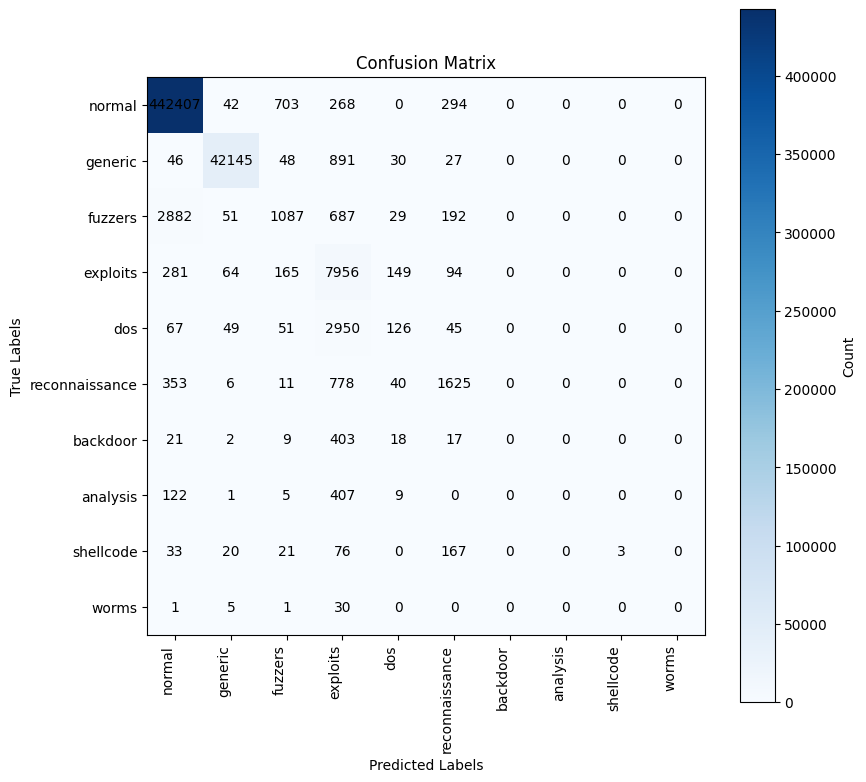

In [142]:
import matplotlib.pyplot as plt

# Define labels for your classes
class_names = labels

# Create a heatmap from the confusion matrix
plt.figure(figsize=(9, 9))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar(label='Count')
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, cm[i, j], ha='center', va='center', fontsize=10)
plt.xticks(range(len(class_names)), class_names, rotation=90, ha='right')
plt.yticks(range(len(class_names)), class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()


In [143]:
import warnings
warnings.filterwarnings('ignore') 
print("CNN Result: \n")
print(classification_report(y_test.argmax(axis=1), y_pred_labels, target_names=class_names))

CNN Result: 

                precision    recall  f1-score   support

        normal       0.99      1.00      0.99    443714
       generic       0.99      0.98      0.99     43187
       fuzzers       0.52      0.22      0.31      4928
      exploits       0.55      0.91      0.69      8709
           dos       0.31      0.04      0.07      3288
reconnaissance       0.66      0.58      0.62      2813
      backdoor       0.00      0.00      0.00       470
      analysis       0.00      0.00      0.00       544
     shellcode       1.00      0.01      0.02       320
         worms       0.00      0.00      0.00        37

      accuracy                           0.98    508010
     macro avg       0.50      0.37      0.37    508010
  weighted avg       0.97      0.98      0.97    508010

